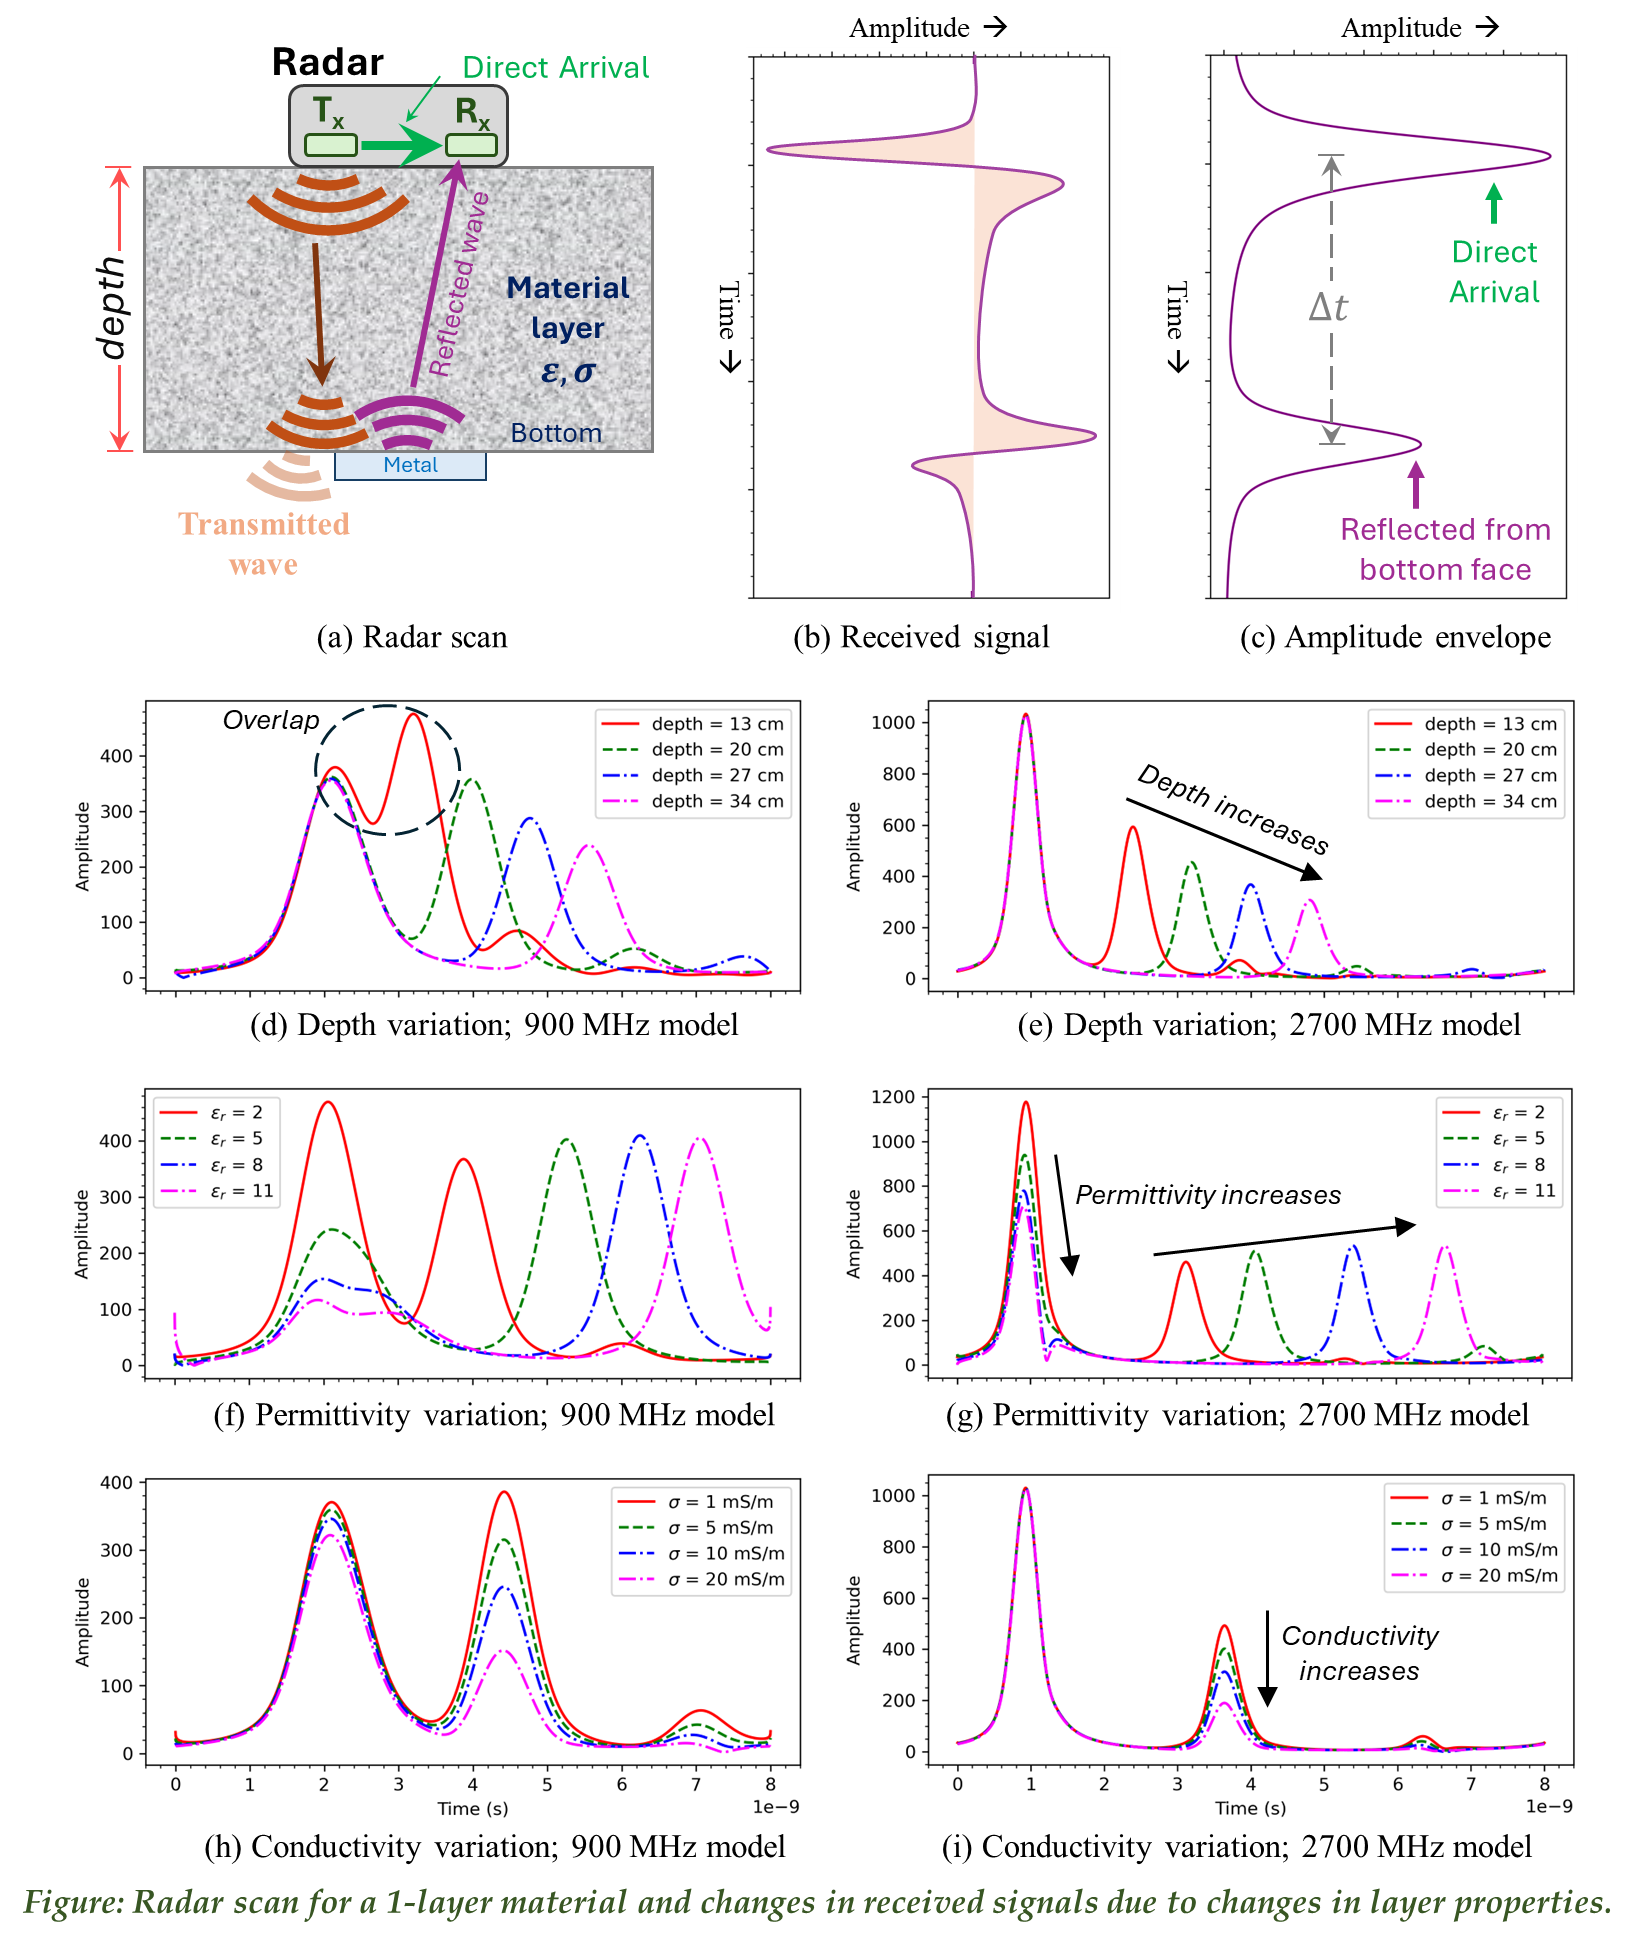
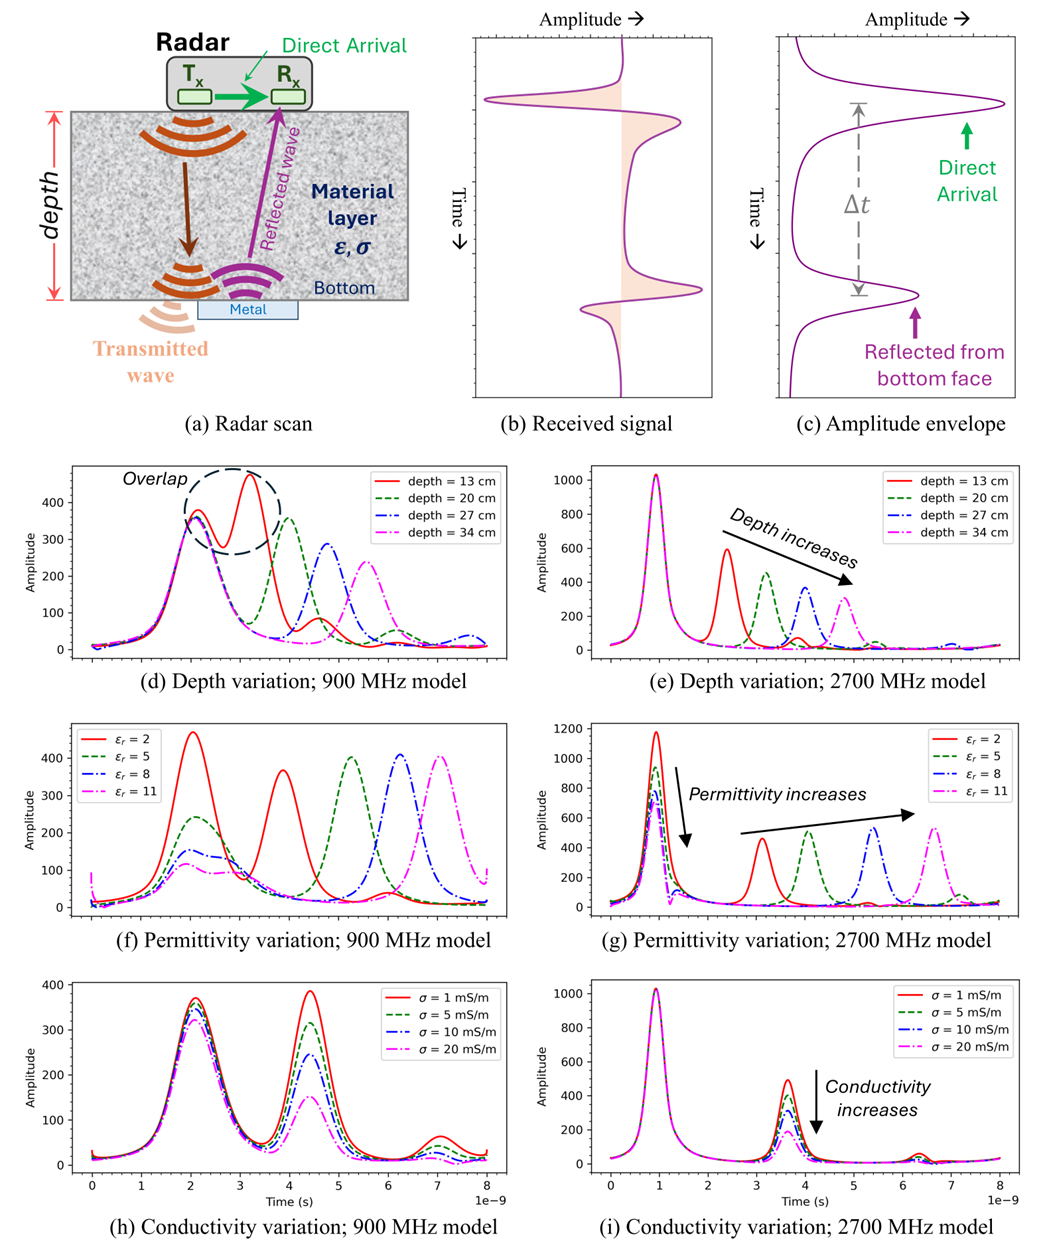

# Packages and Utility functions

#### All necessary packages and gprMax need to be installed to run the following codes

In [1]:
import numpy as np; 
import pandas as pd; 
import matplotlib.pyplot as plt; 
plt.rcParams['figure.figsize'] = (10, 2);
from gprMax.utilities import detect_check_gpus; 
from gprMax.gprMax import api; 
import h5py; 
detect_check_gpus([1]);
import os; 
import torch
import time; 
from IPython.display import clear_output; 
os.getcwd(); 
from GPUtil import showUtilization as gpu_usage
from numba import cuda; 
import gc; 
import pycuda.driver; 
import random; 
from scipy.signal import hilbert
from bayes_opt import BayesianOptimization; 

def free_gpu_cache():
    gc.collect(); 
    torch.cuda.empty_cache(); 
    cuda.select_device(1); 
    cuda.close(); 
    cuda.select_device(1); 
    gpu_usage()
free_gpu_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def norm(signal):
    signal = np.abs(hilbert(signal))    
    return signal

| ID | GPU | MEM |
------------------
|  0 | 10% | 97% |
|  1 |  0% |  2% |


# Effect of parameter change on GPR A-scans

## 2700 MHz model

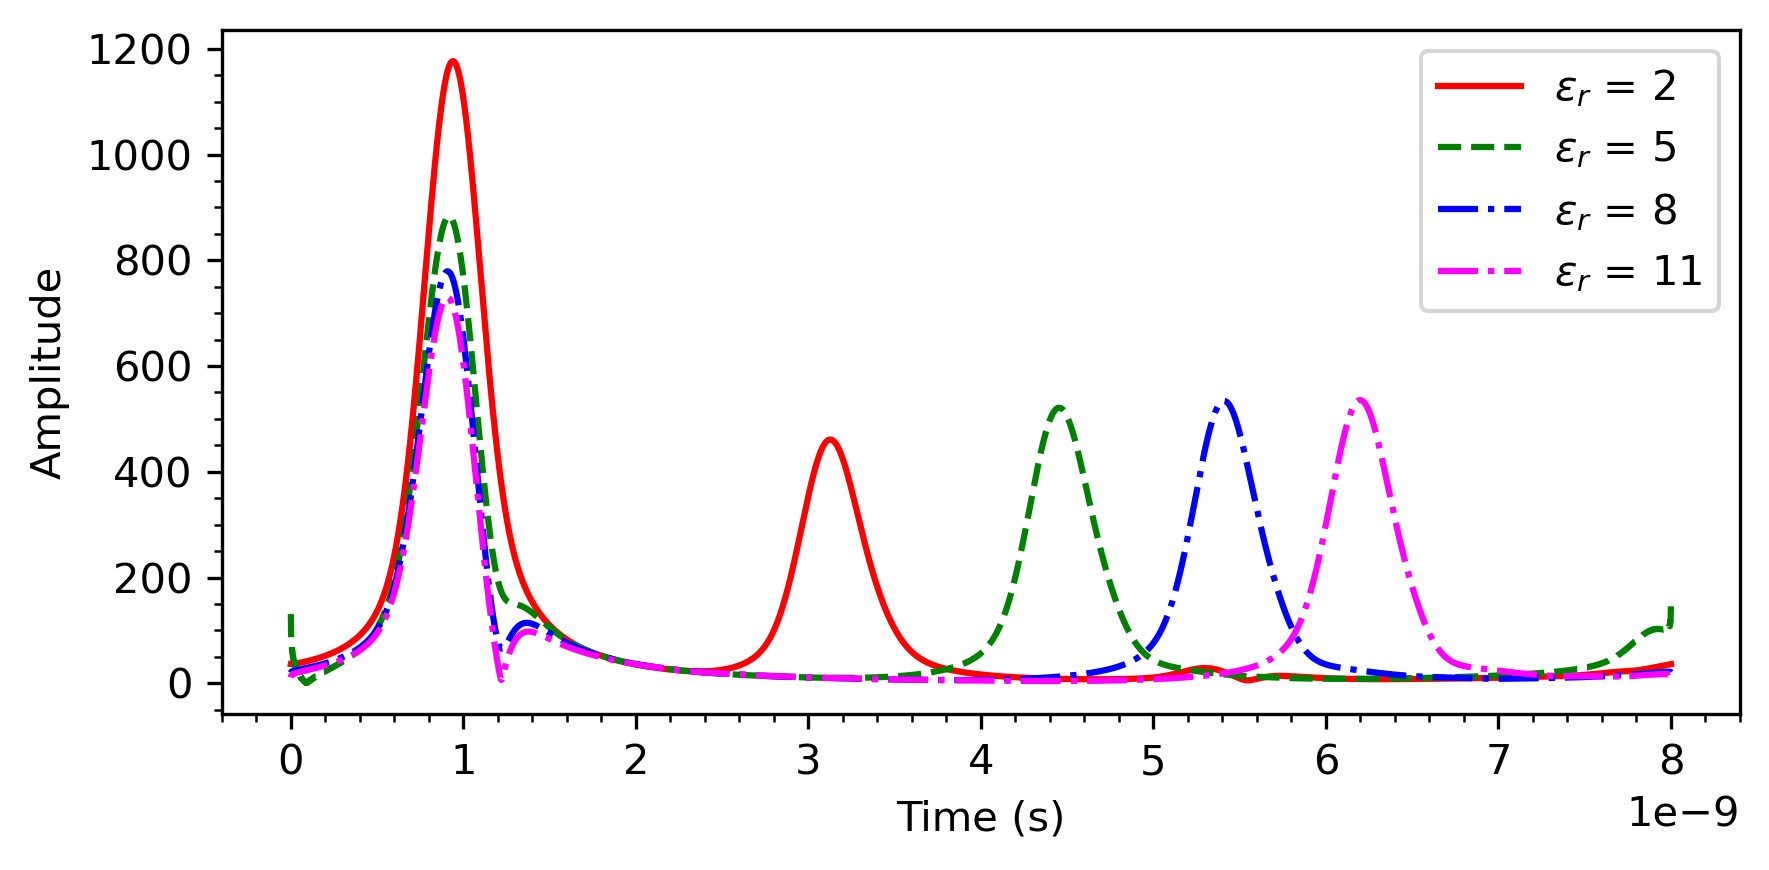

In [2]:
tw= 8e-9;    
def model_2D(p1,c1,p2,c2, dep, waveform, freq, bs, dd):
    b=0.02
    X=0.4; Y=0.5; dx=0.001; Z=dx; gpr_Y = dep+b+dd; freq = freq; Tx=X/2-0.04
    with open("Sens.in", "w") as f:
        f.write(f"#title: Soil_15cm + PEC \n#domain: {X} {Y} {Z}\n#dx_dy_dz: {dx} {dx} {dx}")
        f.write(f"\n#time_window: {tw} \n#material: {p1} {c1} 1 0 mat1 \n#material: {p2} {c2} 1 0 mat2")
        f.write(f"\n#waveform: {waveform} 1 {freq} my_wave")
        f.write(f"\n#hertzian_dipole: z {Tx} {gpr_Y} 0 my_wave\n#rx: {Tx+bs} {gpr_Y} 0")
        f.write(f"\n#box: 0 {b} 0 {X} {dep+b} {Z} mat1")        
        f.write(f"\n#box: 0 {dep+b} 0 {X} {dep+b+2*dd} {Z} mat2")        
        f.write(f"\n#box: 0 {b-.01} 0 {X} {b} {Z} pec")
        f.write(f"\n#geometry_view: 0 0 0 {X} {Y} {Z} {dx} {dx} {dx} Sens n\n")
        f.close()

    api("Sens.in", geometry_only=False, gpu=[1])
    hf2 = h5py.File("Sens.out", 'r', libver='latest', swmr=True)
    Ascan = hf2['rxs/rx1/Ez'][:]
    hf2.close()
    free_gpu_cache();clear_output()
    return Ascan

plt.figure(figsize=(6, 3), dpi=300)

# Intrinsic paramters of 2700 MHz 2D model
p2=1.356; c2=0.0012; waveform="gaussian"; freq=1.44e9; bs=0.062; dd=0.02;

# Uncomment any one of the 3 blocks below to see variation of a single parameter. 
# For instance, the permittivity block is now uncommented

#####_______________________________________________________________________________________________________#####

# PERMITTIVITY variation
sim1 = model_2D(p1=2, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
sim2 = model_2D(p1=5, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
sim3 = model_2D(p1=8, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
sim4 = model_2D(p1=11, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);

t = np.linspace(0, tw, sim1.shape[0]);  
d10 = norm(sim1);       
d20 = norm(sim2);       
d30 = norm(sim3);     
d40 = norm(sim4)

plt.plot(t,d10, label=r'$\epsilon_r$ = 2', linestyle='-', color='r')
plt.plot(t,d20, label=r'$\epsilon_r$ = 5', linestyle='--', color='g')
plt.plot(t,d30, label=r'$\epsilon_r$ = 8', linestyle='-.', color='b')
plt.plot(t,d40, label=r'$\epsilon_r$ = 11', linestyle='-.', color='magenta')

#####_______________________________________________________________________________________________________#####

# # DEPTH variation
# sim1 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.13, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim2 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.20, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim3 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.27, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim4 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.34, waveform=waveform, freq=freq, bs=bs, dd=dd);

# t = np.linspace(0, tw, sim1.shape[0])
# d10 = norm(sim1);       d20 = norm(sim2);       d30 = norm(sim3);     d40 = norm(sim4)

# plt.plot(t,d10, label='depth = 13 cm', linestyle='-', color='r')
# plt.plot(t,d20, label='depth = 20 cm', linestyle='--', color='g')
# plt.plot(t,d30, label='depth = 27 cm', linestyle='-.', color='b')
# plt.plot(t,d40, label='depth = 34 cm', linestyle='-.', color='magenta')

#####_______________________________________________________________________________________________________#####

# # CONDUCTIVITY variation
# sim1 = model_2D(p1=3, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim2 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim3 = model_2D(p1=3, c1=0.010, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim4 = model_2D(p1=3, c1=0.020, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);

# t = np.linspace(0, tw, sim1.shape[0])
# d10 = norm(sim1);       d20 = norm(sim2);       d30 = norm(sim3);     d40 = norm(sim4)

# plt.plot(t,d10, label=r'$\sigma$ = 1 mS/m', linestyle='-', color='r')
# plt.plot(t,d20, label=r'$\sigma$ = 5 mS/m', linestyle='--', color='g')
# plt.plot(t,d30, label=r'$\sigma$ = 10 mS/m', linestyle='-.', color='b')
# plt.plot(t,d40, label=r'$\sigma$ = 20 mS/m', linestyle='-.', color='magenta')

#####_______________________________________________________________________________________________________#####



# Do not comment out the lines below
plt.xlabel('Time (s)'); plt.minorticks_on()
plt.ylabel('Amplitude')
plt.legend(loc='best'); 
plt.tight_layout(); plt.show(); 

## 900 MHz model

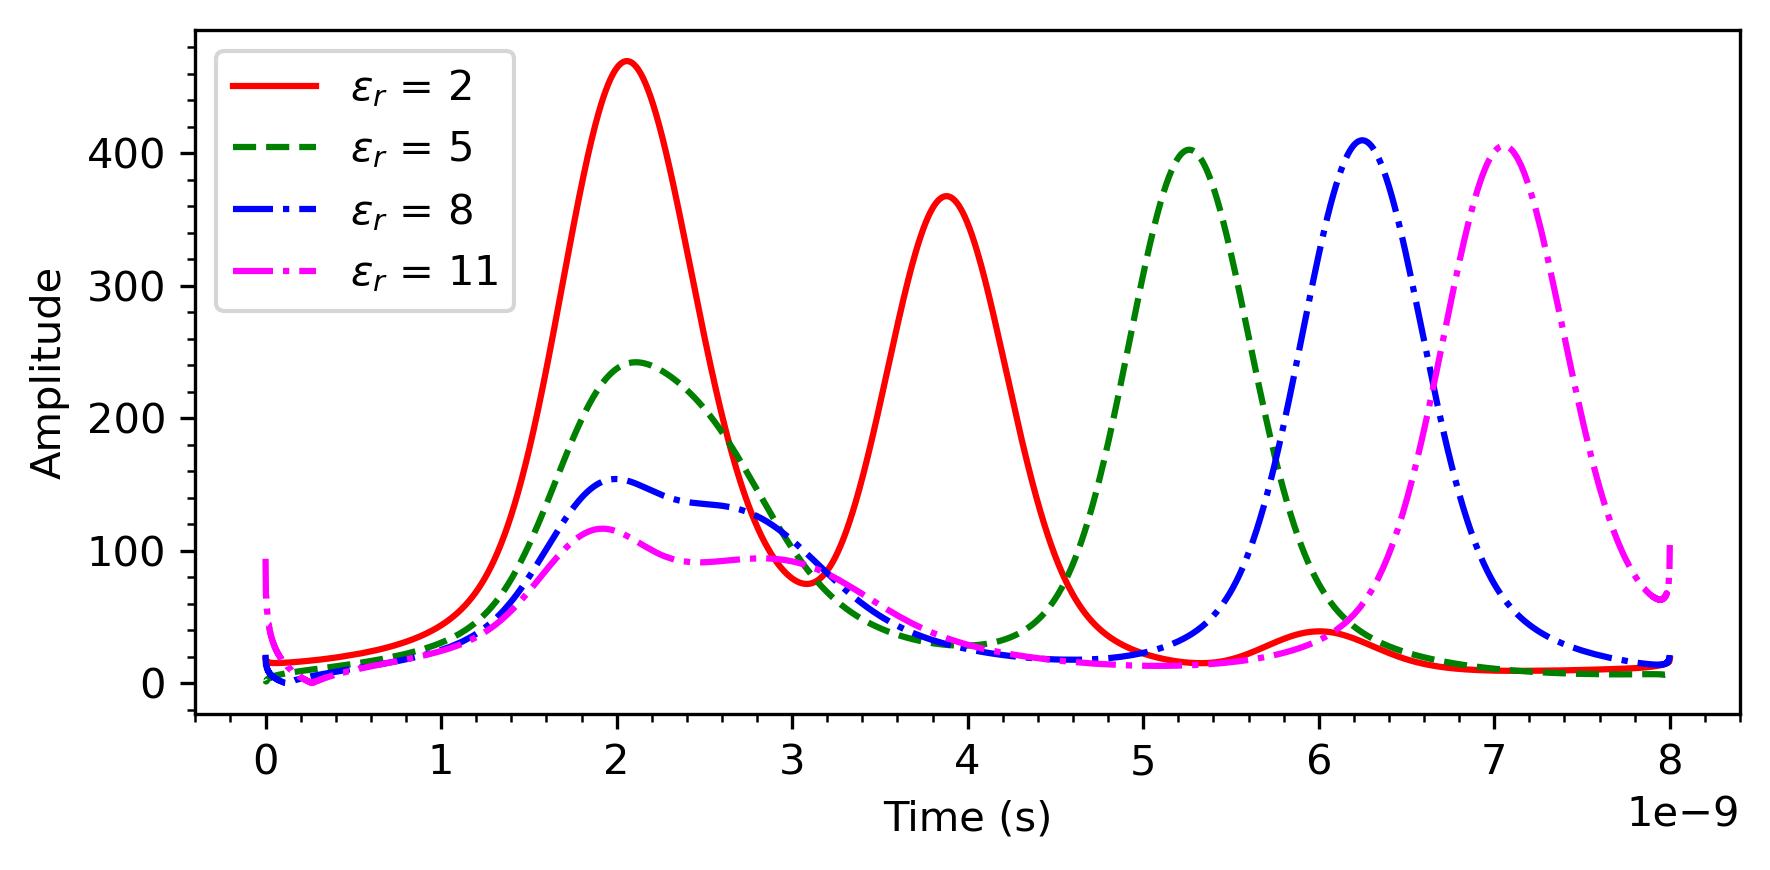

In [3]:
tw= 8e-9;    
def model_2D(p1,c1,p2,c2, dep, waveform, freq, bs, dd):
    b=0.02
    X=0.4; Y=0.5; dx=0.001; Z=dx; gpr_Y = dep+b+dd; freq = freq; Tx=X/2-0.04
    with open("Sens.in", "w") as f:
        f.write(f"#title: Soil_15cm + PEC \n#domain: {X} {Y} {Z}\n#dx_dy_dz: {dx} {dx} {dx}")
        f.write(f"\n#time_window: {tw} \n#material: {p1} {c1} 1 0 mat1 \n#material: {p2} {c2} 1 0 mat2")
        f.write(f"\n#waveform: {waveform} 1 {freq} my_wave")
        f.write(f"\n#hertzian_dipole: z {Tx} {gpr_Y} 0 my_wave\n#rx: {Tx+bs} {gpr_Y} 0")
        f.write(f"\n#box: 0 {b} 0 {X} {dep+b} {Z} mat1")        
        f.write(f"\n#box: 0 {dep+b} 0 {X} {dep+b+2*dd} {Z} mat2")        
        f.write(f"\n#box: 0 {b-.01} 0 {X} {b} {Z} pec")
        f.write(f"\n#geometry_view: 0 0 0 {X} {Y} {Z} {dx} {dx} {dx} Sens n\n")
        f.close()

    api("Sens.in", geometry_only=False, gpu=[1])
    hf2 = h5py.File("Sens.out", 'r', libver='latest', swmr=True)
    Ascan = hf2['rxs/rx1/Ez'][:]
    hf2.close()
    free_gpu_cache();clear_output()
    return Ascan

plt.figure(figsize=(6, 3), dpi=300)

# Intrinsic paramters of 900 MHz 2D model
p2=1.08; c2=0.0015; waveform="gaussian"; freq=0.69e9; bs=0.153; dd=0.011;

#####_______________________________________________________________________________________________________#####

# PERMITTIVITY variation
sim1 = model_2D(p1=2, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
sim2 = model_2D(p1=5, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
sim3 = model_2D(p1=8, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
sim4 = model_2D(p1=11, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);

t = np.linspace(0, tw, sim1.shape[0]);  
d10 = norm(sim1);       
d20 = norm(sim2);       
d30 = norm(sim3);     
d40 = norm(sim4)

plt.plot(t,d10, label=r'$\epsilon_r$ = 2', linestyle='-', color='r')
plt.plot(t,d20, label=r'$\epsilon_r$ = 5', linestyle='--', color='g')
plt.plot(t,d30, label=r'$\epsilon_r$ = 8', linestyle='-.', color='b')
plt.plot(t,d40, label=r'$\epsilon_r$ = 11', linestyle='-.', color='magenta')

#####_______________________________________________________________________________________________________#####

# # DEPTH variation
# sim1 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.13, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim2 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.20, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim3 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.27, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim4 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.34, waveform=waveform, freq=freq, bs=bs, dd=dd);

# t = np.linspace(0, tw, sim1.shape[0])
# d10 = norm(sim1);       d20 = norm(sim2);       d30 = norm(sim3);     d40 = norm(sim4)

# plt.plot(t,d10, label='depth = 13 cm', linestyle='-', color='r')
# plt.plot(t,d20, label='depth = 20 cm', linestyle='--', color='g')
# plt.plot(t,d30, label='depth = 27 cm', linestyle='-.', color='b')
# plt.plot(t,d40, label='depth = 34 cm', linestyle='-.', color='magenta')

#####_______________________________________________________________________________________________________#####

# # CONDUCTIVITY variation
# sim1 = model_2D(p1=3, c1=0.001, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim2 = model_2D(p1=3, c1=0.005, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim3 = model_2D(p1=3, c1=0.010, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);
# sim4 = model_2D(p1=3, c1=0.020, p2=p2, c2=c2, dep=0.239, waveform=waveform, freq=freq, bs=bs, dd=dd);

# t = np.linspace(0, tw, sim1.shape[0])
# d10 = norm(sim1);       d20 = norm(sim2);       d30 = norm(sim3);     d40 = norm(sim4)

# plt.plot(t,d10, label=r'$\sigma$ = 1 mS/m', linestyle='-', color='r')
# plt.plot(t,d20, label=r'$\sigma$ = 5 mS/m', linestyle='--', color='g')
# plt.plot(t,d30, label=r'$\sigma$ = 10 mS/m', linestyle='-.', color='b')
# plt.plot(t,d40, label=r'$\sigma$ = 20 mS/m', linestyle='-.', color='magenta')

#####_______________________________________________________________________________________________________#####



plt.xlabel('Time (s)'); plt.minorticks_on()
plt.ylabel('Amplitude')
plt.legend(loc='best'); 
plt.tight_layout(); plt.show(); 